In [1]:
# Importing libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import cv2
from PIL import Image
from tqdm import tqdm


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, callbacks
from sklearn.model_selection import train_test_split
import logging

# Set up logging for better monitoring and debugging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Set a random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Function to check GPU availability and set memory growth
def setup_environment():
    logging.info(f"TensorFlow version: {tf.__version__}")
    
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        logging.info(f"GPUs detected: {len(gpus)}")
        for gpu in gpus:
            logging.info(f" - {gpu}")
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
                logging.info(f"Memory growth set for {gpu}")
            except RuntimeError as e:
                logging.error(f"Memory growth setting failed for {gpu}: {e}")
    else:
        logging.warning("No GPU detected, using CPU...")

setup_environment()

# Configuration parameters for the model
BATCH_SIZE = 16  # Consider experimenting with this value
EPOCHS = 100  # Reduced to avoid overfitting; EarlyStopping will be used
LEARNING_RATE = 0.001
IMAGE_SIZE = (224, 224)  # Consider varying this based on your dataset

# Implement Early Stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,  # Stop after 10 epochs of no improvement
    restore_best_weights=True  # Restore the best model's weights
)

# Implement Learning Rate Scheduler
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Reduce LR if validation loss plateaus
    factor=0.5,  # Reduce LR by half
    patience=5,  # Wait for 5 epochs before reducing
    min_lr=1e-6  # Set a lower bound for the learning rate
)

# Function to log configurations
def log_configurations():
    logging.info("Model Configuration:")
    logging.info(f"BATCH_SIZE: {BATCH_SIZE}")
    logging.info(f"IMAGE_SIZE: {IMAGE_SIZE}")
    logging.info(f"EPOCHS: {EPOCHS}")
    logging.info(f"LEARNING_RATE: {LEARNING_RATE}")

log_configurations()


INFO: TensorFlow version: 2.18.0
INFO: Model Configuration:
INFO: BATCH_SIZE: 16
INFO: IMAGE_SIZE: (224, 224)
INFO: EPOCHS: 100
INFO: LEARNING_RATE: 0.001


In [5]:
import logging

# Set up logging configuration
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

class Hyperparameters:
    DEFAULT_IMAGE_SIZE = 224  # Can be adjusted globally if needed
    DEFAULT_BATCH_SIZE = 16
    DEFAULT_CHANNELS = 3
    DEFAULT_LEARNING_RATE = 0.001

    VALID_IMAGE_SIZES = [128, 256, 512]
    VALID_BATCH_SIZES = [16, 32, 64]  # Added a list of valid batch sizes
    VALID_CHANNELS = [1, 3]

    def __init__(self, image_size: int = None, batch_size: int = None, channels: int = None, learning_rate: float = None):
        self.image_size = image_size or self.DEFAULT_IMAGE_SIZE
        self.batch_size = batch_size or self.DEFAULT_BATCH_SIZE
        self.channels = channels or self.DEFAULT_CHANNELS
        self.learning_rate = learning_rate or self.DEFAULT_LEARNING_RATE
        self.validate_hyperparameters()

    def validate_hyperparameters(self):
        """Validate and log hyperparameters."""
        if self.image_size not in self.VALID_IMAGE_SIZES:
            logging.warning(f"IMAGE_SIZE {self.image_size} is unusual; consider using {self.VALID_IMAGE_SIZES} for optimal performance.")
        
        if self.batch_size not in self.VALID_BATCH_SIZES:
            logging.warning(f"BATCH_SIZE {self.batch_size} is unusual; consider using {self.VALID_BATCH_SIZES} for optimal performance.")

        if self.batch_size <= 0:
            raise ValueError("BATCH_SIZE must be positive.")
        
        if self.channels not in self.VALID_CHANNELS:
            raise ValueError("CHANNELS should be 1 for grayscale or 3 for RGB.")

        logging.info(f"Set IMAGE_SIZE: {self.image_size}, BATCH_SIZE: {self.batch_size}, CHANNELS: {self.channels}, LEARNING_RATE: {self.learning_rate}")
    
    def update_hyperparameters(self, image_size: int = None, batch_size: int = None, channels: int = None, learning_rate: float = None):
        """Update hyperparameters dynamically."""
        if image_size is not None:
            self.image_size = image_size
            logging.info(f"Updated IMAGE_SIZE to: {self.image_size}")
        if batch_size is not None:
            self.batch_size = batch_size
            logging.info(f"Updated BATCH_SIZE to: {self.batch_size}")
        if channels is not None:
            self.channels = channels
            logging.info(f"Updated CHANNELS to: {self.channels}")
        if learning_rate is not None:
            self.learning_rate = learning_rate
            logging.info(f"Updated LEARNING_RATE to: {self.learning_rate}")
        self.validate_hyperparameters()
    
    def display_hyperparameters(self):
        """Display current hyperparameters."""
        logging.info(f"Current Hyperparameters - IMAGE_SIZE: {self.image_size}, BATCH_SIZE: {self.batch_size}, CHANNELS: {self.channels}, LEARNING_RATE: {self.learning_rate}")

# Example usage: Initialize with custom values or defaults
hyperparams = Hyperparameters()
hyperparams.display_hyperparameters()


INFO: Set IMAGE_SIZE: 224, BATCH_SIZE: 16, CHANNELS: 3, LEARNING_RATE: 0.001
INFO: Current Hyperparameters - IMAGE_SIZE: 224, BATCH_SIZE: 16, CHANNELS: 3, LEARNING_RATE: 0.001


In [8]:
import logging
import tensorflow as tf
from tensorflow.keras import layers

# Set up logging configuration
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Dataset path
dataset_path = 'Dataset'

# Function to load and split dataset with enhanced error handling and optimizations
def load_datasets(dataset_path: str, image_size=(256, 256), batch_size=32, seed=42):
    try:
        logging.info("Loading dataset from: %s", dataset_path)

        # Data augmentation layer
        data_augmentation = tf.keras.Sequential([
            layers.RandomFlip("horizontal_and_vertical"),
            layers.RandomRotation(0.2),
            layers.RandomZoom(0.1),
        ])

        train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
            dataset_path,
            shuffle=True,
            image_size=image_size,
            batch_size=batch_size,
            validation_split=0.2,
            seed=seed,
            color_mode='rgb',  # Set according to your image channels
            subset='training'
        ).map(lambda x, y: (data_augmentation(x, training=True), y))  # Apply data augmentation

        validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
            dataset_path,
            shuffle=True,
            image_size=image_size,
            batch_size=batch_size,
            validation_split=0.2,
            seed=seed,
            color_mode='rgb',  # Set according to your image channels
            subset='validation'
        )

        # Prefetch the datasets for performance improvement
        train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

        logging.info("Datasets loaded successfully.")
        return train_dataset, validation_dataset
    
    except Exception as e:
        logging.error("Error loading dataset: %s", e)  # Fixed the string literal
        raise

# Example usage
train_dataset, validation_dataset = load_datasets(dataset_path)


INFO: Loading dataset from: Dataset


Found 2900 files belonging to 3 classes.
Using 2320 files for training.
Found 2900 files belonging to 3 classes.
Using 580 files for validation.


INFO: Datasets loaded successfully.


INFO: Loading training dataset...


Found 2900 files belonging to 3 classes.
Using 2320 files for training.


INFO: Loaded 73 batches of training dataset.
INFO: Loading validation dataset...


Found 2900 files belonging to 3 classes.
Using 580 files for validation.


INFO: Loaded 19 batches of validation dataset.
INFO: Class names: ['Healthly', 'Powdery Mildew', 'Tomato Spotted Wilt Virus']


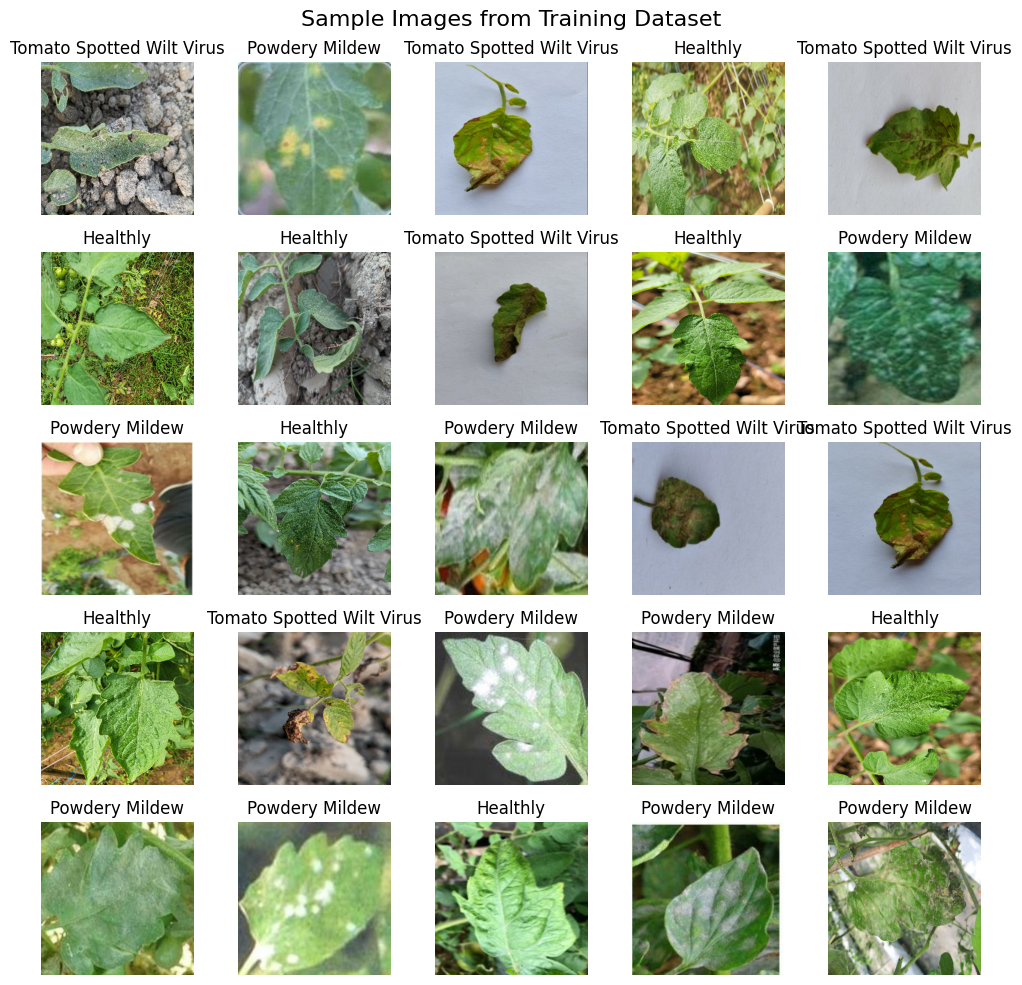

INFO: Dataset loading and preprocessing completed successfully.


In [9]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Set up logging configuration
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Dataset path
dataset_path = 'Dataset'

def load_dataset(dataset_path: str, image_size=(256, 256), batch_size=32, subset="training", seed=42):
    """Load dataset from directory with specified parameters."""
    try:
        logging.info(f"Loading {subset} dataset...")
        dataset = tf.keras.preprocessing.image_dataset_from_directory(
            dataset_path,
            shuffle=True,
            image_size=image_size,
            batch_size=batch_size,
            validation_split=0.2,
            subset=subset,
            seed=seed
        )
        logging.info(f"Loaded {len(dataset)} batches of {subset} dataset.")
        return dataset
    except Exception as e:
        logging.error(f"Error loading {subset} dataset: {e}")
        raise

# Load and preprocess datasets
train_dataset = load_dataset(
    dataset_path,
    image_size=(hyperparams.image_size, hyperparams.image_size),
    batch_size=hyperparams.batch_size,
    subset="training",
    seed=SEED
)
validation_dataset = load_dataset(
    dataset_path,
    image_size=(hyperparams.image_size, hyperparams.image_size),
    batch_size=hyperparams.batch_size,
    subset="validation",
    seed=SEED
)

# Extract class names from the training dataset
class_names = train_dataset.class_names
logging.info(f"Class names: {class_names}")

# Normalize pixel values to [0, 1] range for both datasets
def normalize(image, label):
    """Normalize image pixel values."""
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply normalization to both datasets
train_dataset = train_dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

# Optimize performance: cache and prefetch data
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Function to visualize sample images with class labels
def plot_sample_images(dataset, class_names, num_images=9):
    """Visualize sample images from the dataset."""
    plt.figure(figsize=(10, 10))
    grid_size = int(np.ceil(np.sqrt(num_images)))

    for images, labels in dataset.take(1):
        for i in range(min(num_images, images.shape[0])):
            ax = plt.subplot(grid_size, grid_size, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(class_names[labels[i].numpy()])  # Ensure labels are numpy
            plt.axis("off")

    plt.suptitle("Sample Images from Training Dataset", fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize sample images
plot_sample_images(train_dataset, class_names, num_images=25)

# Log completion of dataset preparation
logging.info("Dataset loading and preprocessing completed successfully.")


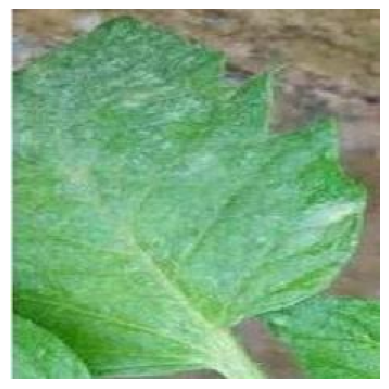

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import os

# Set the dataset path
dataset_path = "C:\\Users\\sakib\\Downloads\\Tomato\\Dataset"

# Function to load images from a specified path and visualize one at random
def visualize_random_image_from_path(dataset_path):
    # Get all class subfolders (each subfolder represents a class)
    class_subfolders = [os.path.join(dataset_path, subfolder) for subfolder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, subfolder))]
    
    # Select a random class and a random image from that class
    random_class_folder = random.choice(class_subfolders)
    image_files = [os.path.join(random_class_folder, img) for img in os.listdir(random_class_folder) if img.endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_files:
        print("No images found in the selected class folder.")
        return
    
    random_image_path = random.choice(image_files)
    image = tf.keras.preprocessing.image.load_img(random_image_path, target_size=(256, 256))
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_array = np.clip(image_array, 0, 255).astype('uint8')

    # Display the image
    plt.imshow(image_array)
    plt.axis("off")
    plt.show()

# Visualize a random image
visualize_random_image_from_path(dataset_path)


Found 2900 files belonging to 3 classes.


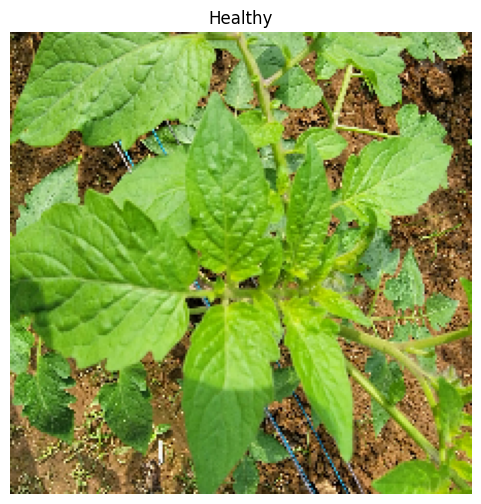

INFO: Displayed random image with class 'Healthy'


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import logging

# Function to load dataset and ensure correct structure
def load_dataset(dataset_path):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_path,
        image_size=(224, 224),  # Match to your model's expected input
        batch_size=16,
        seed=123
    )
    return dataset

# Visualization function
def visualize_random_image_from_batch(dataset, class_names, figsize=(6, 6)):
    """Visualize a random image from a batch in the dataset with proper scaling and RGB handling."""
    plt.figure(figsize=figsize)
    try:
        for image_batch, label_batch in dataset.take(1):
            # Select a random image from the batch
            image_index = random.randint(0, image_batch.shape[0] - 1)
            
            # Convert image to numpy array and ensure range is correct
            image = image_batch[image_index].numpy()
            if image.max() <= 1.0:  # Check if it's scaled [0, 1]
                image = (image * 255).astype("uint8")
            else:
                image = np.clip(image, 0, 255).astype("uint8")
            
            # Ensure RGB format for display
            if image.shape[-1] == 1:  # Grayscale check
                image = np.repeat(image, 3, axis=-1)

            plt.imshow(image)
            plt.title(class_names[int(label_batch[image_index].numpy())], fontsize=12)
            plt.axis("off")
            plt.show()

            logging.info(f"Displayed random image with class '{class_names[int(label_batch[image_index].numpy())]}'")

    except Exception as e:
        logging.error(f"Error visualizing image: {e}")

# Example usage
dataset_path = "C:\\Users\\sakib\\Downloads\\Tomato\\Dataset"
class_names = ["Healthy", "Powdery Mildew", "Tomato Spotted Wilt Virus"]  # Adjust to your class labels

# Load and visualize
train_dataset = load_dataset(dataset_path)
visualize_random_image_from_batch(train_dataset, class_names)


In [9]:
import logging
import tensorflow as tf

def get_dataset_partitions_tf(
    ds: tf.data.Dataset, 
    train_split: float = 0.8, 
    val_split: float = 0.1, 
    test_split: float = 0.1, 
    shuffle: bool = True, 
    shuffle_size: int = 10000, 
    shuffle_seed: int = 12
) -> tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
    """Partition a TensorFlow dataset into training, validation, and test sets.

    Args:
        ds: The input dataset.
        train_split: Proportion of the dataset to be used for training.
        val_split: Proportion of the dataset to be used for validation.
        test_split: Proportion of the dataset to be used for testing.
        shuffle: Boolean indicating whether to shuffle the dataset.
        shuffle_size: Size of the buffer for shuffling.
        shuffle_seed: Seed for reproducibility in shuffling.

    Returns:
        A tuple of three datasets: (train_ds, val_ds, test_ds).
    """
    # Validate the split ratios
    total_split = train_split + val_split + test_split
    if total_split != 1.0:
        raise ValueError("Train, validation, and test splits must sum to 1.0.")
    if any(x < 0 for x in [train_split, val_split, test_split]):
        raise ValueError("Split ratios must be non-negative.")

    ds_size = tf.data.experimental.cardinality(ds).numpy()
    
    if ds_size == 0:
        raise ValueError("Dataset is empty. Please provide a valid dataset.")

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=shuffle_seed)
        logging.info("Dataset shuffled with buffer size: %d and seed: %d.", shuffle_size, shuffle_seed)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    if train_size <= 0 or val_size <= 0 or (ds_size - train_size - val_size) <= 0:
        raise ValueError("One of the splits is too small. Please adjust the split ratios.")

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    logging.info(f"Dataset sizes - Train: {train_size}, Validation: {val_size}, Test: {ds_size - train_size - val_size} (Total: {ds_size})")
    
    return train_ds, val_ds, test_ds

# Example of using the function
train_ds, val_ds, test_ds = get_dataset_partitions_tf(train_dataset, train_split=0.8, val_split=0.1, test_split=0.1)


INFO: Dataset shuffled with buffer size: 10000 and seed: 12.
INFO: Dataset sizes - Train: 58, Validation: 7, Test: 8 (Total: 73)


In [10]:
import tensorflow as tf
import logging

# Define constants
IMAGE_SIZE = (224, 224)  # Change as needed
BATCH_SIZE = 32
SEED = 123

# Normalize function
def normalize(image, label):
    """Normalize image pixel values to [0, 1]."""
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Load and normalize dataset function
def load_and_normalize_dataset(dataset_path, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, seed=SEED):
    """Load and normalize the dataset from a directory."""
    try:
        logging.info("Loading dataset...")

        # Load training dataset
        train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
            dataset_path,
            shuffle=True,
            image_size=image_size,
            batch_size=batch_size,
            validation_split=0.2,
            subset="training",  # Specify the training subset
            seed=seed
        )

        # Load validation dataset
        validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
            dataset_path,
            shuffle=True,
            image_size=image_size,
            batch_size=batch_size,
            validation_split=0.2,
            subset="validation",  # Specify the validation subset
            seed=seed
        )

        class_names = train_dataset.class_names
        logging.info(f"Class names: {class_names}")

        # Normalize datasets
        train_dataset = train_dataset.map(normalize).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
        validation_dataset = validation_dataset.map(normalize).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

        logging.info(f"Dataset sizes - Training: {tf.data.experimental.cardinality(train_dataset).numpy()}, Validation: {tf.data.experimental.cardinality(validation_dataset).numpy()}")

        return train_dataset, validation_dataset, class_names

    except Exception as e:
        logging.error(f"Error loading dataset: {e}")
        raise

# Load and normalize datasets
dataset_path = 'Dataset'  # Define your dataset path
train_dataset, validation_dataset, class_names = load_and_normalize_dataset(dataset_path)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

# Apply data augmentation to the training dataset
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Example of using callbacks for early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,  # Number of epochs to wait before stopping
    restore_best_weights=True
)

# You can now use train_dataset and validation_dataset for training and evaluation.


INFO: Loading dataset...


Found 2900 files belonging to 3 classes.
Using 2320 files for training.
Found 2900 files belonging to 3 classes.
Using 580 files for validation.


INFO: Class names: ['Healthly', 'Powdery Mildew', 'Tomato Spotted Wilt Virus']
INFO: Dataset sizes - Training: 73, Validation: 19


In [11]:
import tensorflow as tf
import logging

# Function for data augmentation
def augment(image, label):
    """Apply data augmentation to the image."""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

# Optimize dataset performance with caching and prefetching
def optimize_dataset(ds, shuffle_size=None, augment_data=False):
    """Cache and prefetch the dataset for performance optimization."""
    logging.info("Optimizing dataset performance...")
    
    if augment_data:
        ds = ds.map(augment)  # Apply augmentation if specified

    if shuffle_size:
        ds = ds.shuffle(shuffle_size)
        logging.info(f"Shuffled dataset with buffer size: {shuffle_size}")
    
    optimized_ds = ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    logging.info("Dataset optimization complete.")
    
    return optimized_ds

# Apply optimization to each dataset with augmentation for training set
train_ds = optimize_dataset(train_ds, shuffle_size=1000, augment_data=True)
val_ds = optimize_dataset(val_ds)
test_ds = optimize_dataset(test_ds)

# Early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,  
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,  
    patience=3,  
    min_lr=1e-6  
)

# These callbacks can be included during model training
# model.fit(train_ds, validation_data=val_ds, epochs=num_epochs, callbacks=[early_stopping, reduce_lr])


INFO: Optimizing dataset performance...
INFO: Shuffled dataset with buffer size: 1000
INFO: Dataset optimization complete.
INFO: Optimizing dataset performance...
INFO: Dataset optimization complete.
INFO: Optimizing dataset performance...
INFO: Dataset optimization complete.


In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import logging

# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 123

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

def create_cnn_model(input_shape, num_classes):
    """Creates a CNN model for image classification."""
    model = tf.keras.Sequential([
        layers.Input(shape=input_shape),
        data_augmentation,
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Last convolutional layer with a specific name
        layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01), name='last_conv_layer'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    logging.info("CNN model created.")
    return model

# Create the model
input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
num_classes = len(class_names)  # Get number of classes from class names
cnn_model = create_cnn_model(input_shape, num_classes)

# Log model summary
cnn_model.summary()


INFO: CNN model created.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ last_conv_layer (Conv2D)             │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      12,845,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,236,419 (50.49 MB)

 Trainable params: 13,235,459 (50.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [13]:
import tensorflow as tf
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

# Define the resize and rescale function
def resize_and_rescale(image, image_size=(256, 256)):
    """Resize and rescale the image."""
    image = tf.image.resize(image, image_size)
    image = image / 255.0  # Rescale image from [0, 255] to [0, 1]
    return image

# Load and normalize dataset
def load_and_normalize_dataset(dataset_path, image_size=(256, 256), batch_size=32):
    """Load dataset from directory and normalize images."""
    try:
        dataset = tf.keras.preprocessing.image_dataset_from_directory(
            dataset_path,
            image_size=image_size,
            batch_size=batch_size
        )
        
        class_names = dataset.class_names
        logging.info(f"Class names: {class_names}")

        # Apply resize and rescale to the dataset
        dataset = dataset.map(lambda x, y: (resize_and_rescale(x), y))

        return dataset, class_names
    except Exception as e:
        logging.error(f"Error loading dataset: {e}")
        return None, None

# Optimize dataset performance
def optimize_dataset(dataset, shuffle_size=1000, augment_data=False):
    """Optimize dataset by shuffling and prefetching."""
    if augment_data:
        dataset = dataset.map(lambda x, y: (tf.image.random_flip_left_right(x), y))
    
    dataset = dataset.shuffle(buffer_size=shuffle_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

# Load and normalize the dataset
dataset_path = 'Dataset'  # Define your dataset path
full_dataset, class_names = load_and_normalize_dataset(dataset_path)

# Split the dataset into training and validation sets
val_size = int(0.2 * tf.data.experimental.cardinality(full_dataset).numpy())  # 20% for validation
train_ds = full_dataset.skip(val_size)
val_ds = full_dataset.take(val_size)

# Log dataset sizes after the split
logging.info(f"Training dataset size: {tf.data.experimental.cardinality(train_ds).numpy()}")
logging.info(f"Validation dataset size: {tf.data.experimental.cardinality(val_ds).numpy()}")

# Optimize dataset performance
train_ds = optimize_dataset(train_ds, shuffle_size=1000, augment_data=True)
val_ds = optimize_dataset(val_ds, shuffle_size=1000, augment_data=False)

# Commenting out model training
# history = model.fit(train_ds, validation_data=val_ds, epochs=50, 
#                     callbacks=[early_stopping, reduce_lr])


Found 2900 files belonging to 3 classes.


INFO: Class names: ['Healthly', 'Powdery Mildew', 'Tomato Spotted Wilt Virus']
INFO: Training dataset size: 73
INFO: Validation dataset size: 18


In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)

# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16  # Reduced batch size
SEED = 123

# Enhanced resize and rescale function
def create_resize_and_rescale(image_size):
    if isinstance(image_size, int):
        image_size = (image_size, image_size)
    elif not (isinstance(image_size, tuple) and len(image_size) == 2):
        logging.error("Invalid image_size provided; must be an integer or a tuple of two integers.")
        raise ValueError("image_size must be an integer or a tuple of two integers.")
    
    resize_layer = layers.Resizing(image_size[0], image_size[1])
    rescale_layer = layers.Rescaling(1.0 / 255)

    logging.info(f"Resize layer created: {image_size}")
    logging.info("Rescaling layer created: Scaling pixel values to [0, 1]")

    return tf.keras.Sequential([resize_layer, rescale_layer])

# Create the resizing and rescaling layer
resize_and_rescale = create_resize_and_rescale(IMAGE_SIZE)
logging.info(f"Resize and rescale layer created with target size: {IMAGE_SIZE}")

# Load and normalize dataset function
def load_and_normalize_dataset(dataset_path, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE):
    try:
        logging.info("Loading and normalizing dataset...")
        dataset = tf.keras.preprocessing.image_dataset_from_directory(
            dataset_path,
            shuffle=True,
            image_size=image_size,
            batch_size=batch_size,
            seed=SEED
        )
        class_names = dataset.class_names
        logging.info(f"Class names: {class_names}")

        # Apply resize and rescale to the dataset
        dataset = dataset.map(lambda x, y: (resize_and_rescale(x), y))
        
        return dataset, class_names
    except Exception as e:
        logging.error(f"Error loading dataset: {e}")
        raise

# Load dataset
dataset_path = 'Dataset'  # Define your dataset path
full_dataset, class_names = load_and_normalize_dataset(dataset_path)

# Data augmentation function
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

# Optimize dataset performance
def optimize_dataset(ds, shuffle_size=None, augment_data=False):
    if augment_data:
        ds = ds.map(augment)
    if shuffle_size:
        ds = ds.shuffle(shuffle_size)
    return ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Apply optimization to the full dataset
full_dataset = optimize_dataset(full_dataset, shuffle_size=1000, augment_data=True)

# Split the dataset into training and validation sets (80% train, 20% validation)
val_size = int(0.2 * tf.data.experimental.cardinality(full_dataset).numpy())  # Calculate validation size
train_size = tf.data.experimental.cardinality(full_dataset).numpy() - val_size  # Calculate training size

# Split the dataset
train_ds = full_dataset.take(train_size)
val_ds = full_dataset.skip(train_size)

# Optimize validation dataset performance (without augmentation)
val_ds = optimize_dataset(val_ds, shuffle_size=None, augment_data=False)

# Check cardinality of validation dataset
if val_ds.cardinality().numpy() == 0:
    logging.error("Validation dataset is empty. Please check the dataset splitting.")

# Define the model architecture using transfer learning
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model layers

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks for early stopping, learning rate reduction, and model checkpointing
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model with checkpointing
history = model.fit(train_ds, validation_data=val_ds, epochs=100,  # Reduced epochs for initial run
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Log model performance
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
logging.info(f"Final Training Accuracy: {train_accuracy:.2f}, Validation Accuracy: {val_accuracy:.2f}")

# Optional: Unfreeze some layers of the base model for fine-tuning
base_model.trainable = True  # Unfreeze the base model layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),  # Lower learning rate for fine-tuning
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model (optional)
fine_tune_history = model.fit(train_ds, validation_data=val_ds, epochs=10,  # Reduced epochs for fine-tuning
                               callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Log fine-tuning performance
fine_tune_train_accuracy = fine_tune_history.history['accuracy'][-1]
fine_tune_val_accuracy = fine_tune_history.history['val_accuracy'][-1]
logging.info(f"Fine-tuning Training Accuracy: {fine_tune_train_accuracy:.2f}, Validation Accuracy: {fine_tune_val_accuracy:.2f}")


INFO: Resize layer created: (224, 224)
INFO: Rescaling layer created: Scaling pixel values to [0, 1]
INFO: Resize and rescale layer created with target size: (224, 224)
INFO: Loading and normalizing dataset...


Found 2900 files belonging to 3 classes.


INFO: Class names: ['Healthly', 'Powdery Mildew', 'Tomato Spotted Wilt Virus']


Epoch 1/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 108s 537ms/step - accuracy: 0.4224 - loss: 4.0160 - val_accuracy: 0.7483 - val_loss: 2.8398 - learning_rate: 1.0000e-04
Epoch 2/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 51s 352ms/step - accuracy: 0.6610 - loss: 3.2193 - val_accuracy: 0.8125 - val_loss: 2.6308 - learning_rate: 1.0000e-04
Epoch 3/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 52s 357ms/step - accuracy: 0.7358 - loss: 2.9611 - val_accuracy: 0.8594 - val_loss: 2.5108 - learning_rate: 1.0000e-04
Epoch 4/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 52s 354ms/step - accuracy: 0.7449 - loss: 2.8266 - val_accuracy: 0.8681 - val_loss: 2.4227 - learning_rate: 1.0000e-04
Epoch 5/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 51s 351ms/step - accuracy: 0.7735 - loss: 2.6927 - val_accuracy: 0.8698 - val_loss: 2.3530 - learning_rate: 1.0000e-04
Epoch 6/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 52s 353ms/step - accuracy: 0.8061 - loss: 2.5744 - val_accuracy: 0.8767 - val_loss: 2.2786 - learning_rate: 1.0000e-04
Epoch 7/100
146/146 ━━━━━━━━━━━━━━━━━━━

INFO: Final Training Accuracy: 0.97, Validation Accuracy: 0.91


Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.7782 - loss: 0.9507 - val_accuracy: 0.9167 - val_loss: 0.5408 - learning_rate: 1.0000e-05
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.8512 - loss: 0.6127 - val_accuracy: 0.9080 - val_loss: 0.6041 - learning_rate: 1.0000e-05
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.8973 - loss: 0.4998 - val_accuracy: 0.9028 - val_loss: 0.6131 - learning_rate: 1.0000e-05
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.9160 - loss: 0.4295 - val_accuracy: 0.9028 - val_loss: 0.6251 - learning_rate: 1.0000e-05
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.9233 - loss: 0.3808 - val_accuracy: 0.9115 - val_loss: 0.6124 - learning_rate: 5.0000e-06


INFO: Fine-tuning Training Accuracy: 0.93, Validation Accuracy: 0.91


In [16]:
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]


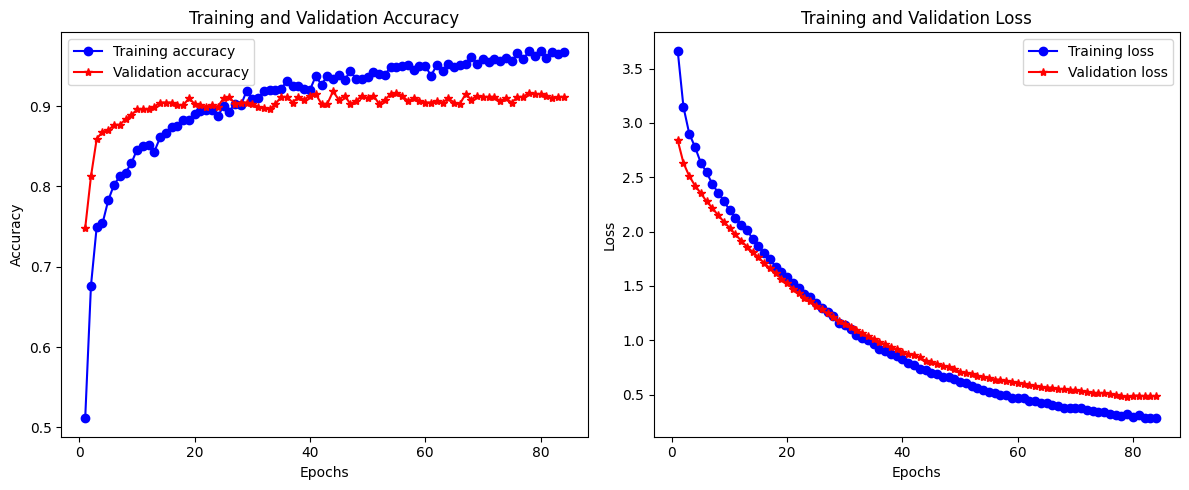

In [17]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    # Extract accuracy and loss values from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plotting Accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r*-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming you have the 'history' object from model training
plot_learning_curves(history)


36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 289ms/step


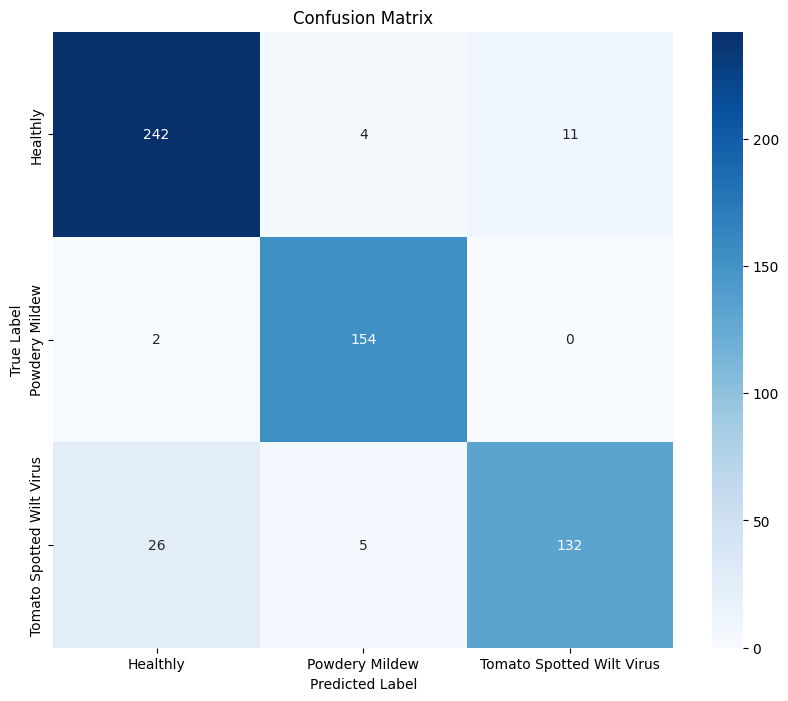

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions for the validation dataset
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)  # Get true labels
y_pred_probs = model.predict(val_ds)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Get predicted labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))


                           precision    recall  f1-score   support

                 Healthly       0.90      0.94      0.92       257
           Powdery Mildew       0.94      0.99      0.97       156
Tomato Spotted Wilt Virus       0.92      0.81      0.86       163

                 accuracy                           0.92       576
                macro avg       0.92      0.91      0.92       576
             weighted avg       0.92      0.92      0.92       576



In [2]:
import matplotlib.pyplot as plt

# Check if the history variable is defined
if 'history' in locals():
    # Plot training & validation accuracy values
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
else:
    print("The 'history' variable is not defined. Please run model.fit() first.")


The 'history' variable is not defined. Please run model.fit() first.


36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 277ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 288ms/step


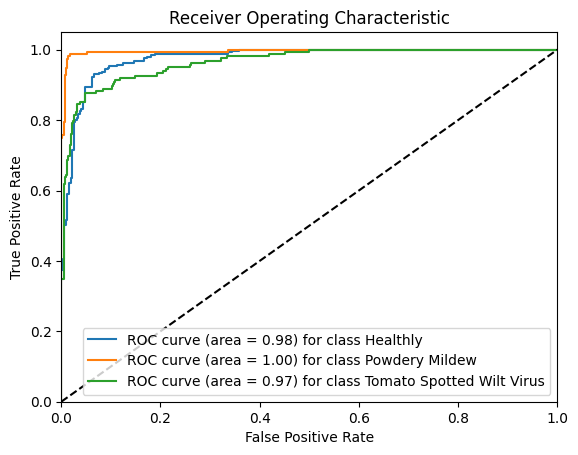

In [20]:
from sklearn.metrics import roc_curve, auc

# One-vs-Rest ROC for each class
for i in range(len(class_names)):
    y_true_binary = (y_true == i).astype(int)
    y_scores = model.predict(val_ds)[:, i]
    fpr, tpr, _ = roc_curve(y_true_binary, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for class {class_names[i]}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


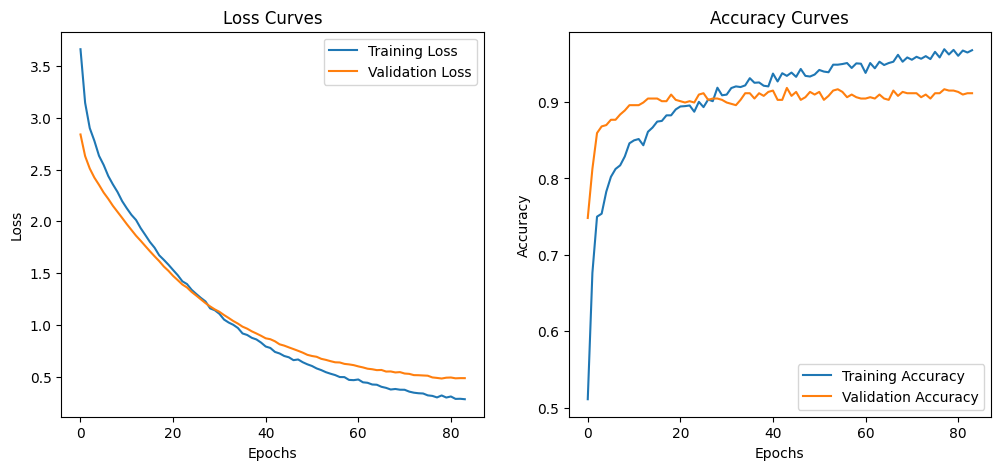

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [25]:
from sklearn.metrics import f1_score

f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1:.2f}')


F1 Score: 0.92


In [26]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_true, y_pred)
print(f'Matthews Correlation Coefficient: {mcc:.2f}')


Matthews Correlation Coefficient: 0.87


In [27]:
from sklearn.metrics import roc_auc_score

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_true, model.predict(val_ds), multi_class='ovr')
print(f'ROC AUC: {roc_auc:.2f}')


36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 290ms/step
ROC AUC: 0.98


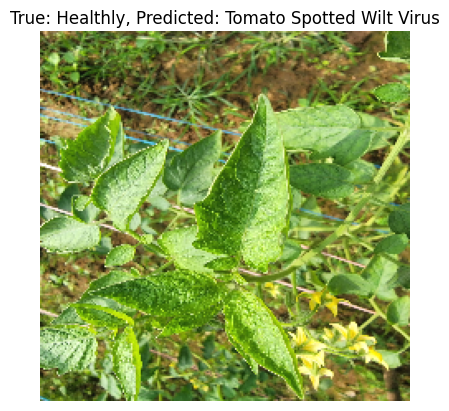

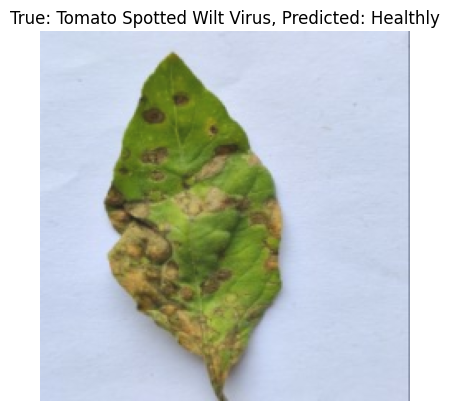

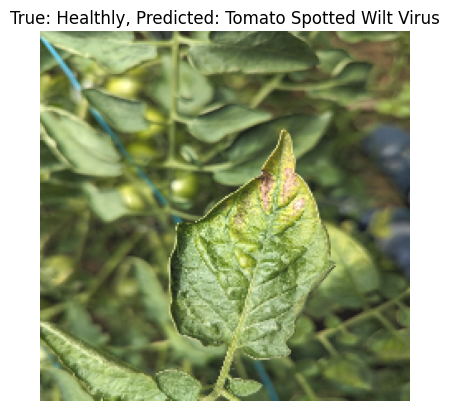

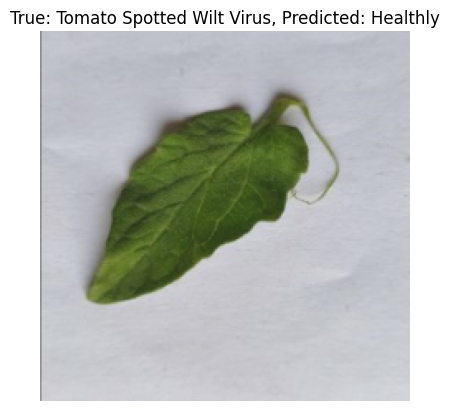

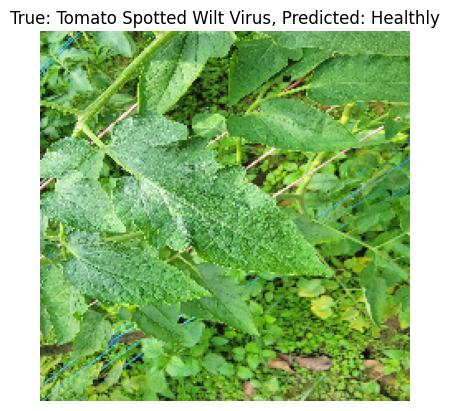

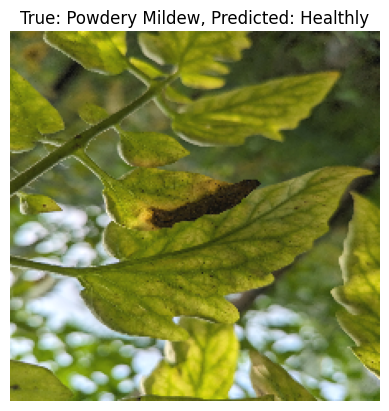

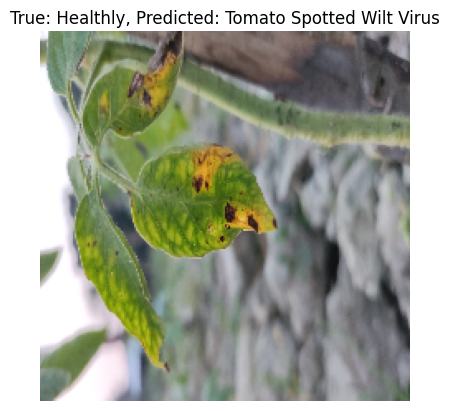

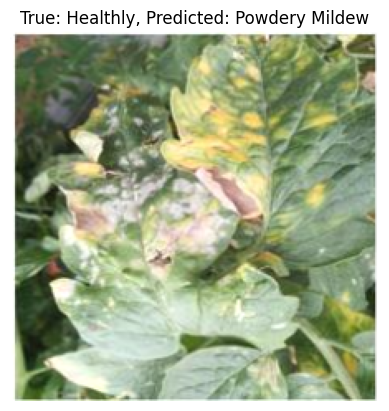

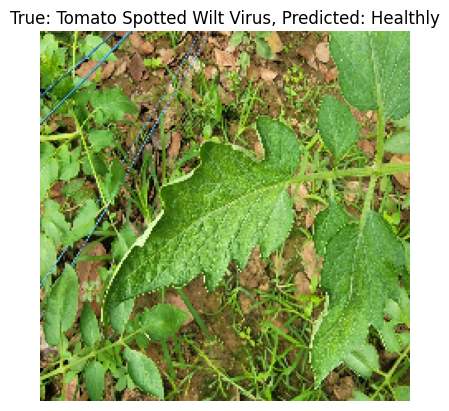

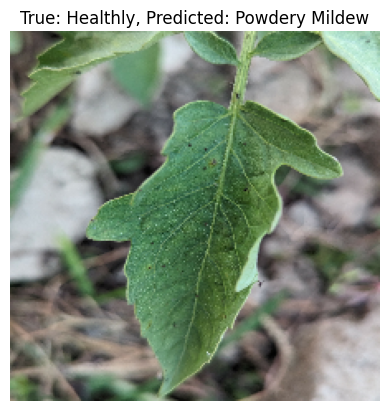

In [30]:
# Visualize a few misclassified examples
misclassified_indices = np.where(y_true != y_pred)[0]
for i in range(min(10, len(misclassified_indices))):
    index = misclassified_indices[i]
    plt.imshow(X[index])
    plt.title(f'True: {class_names[y_true[index]]}, Predicted: {class_names[y_pred[index]]}')
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

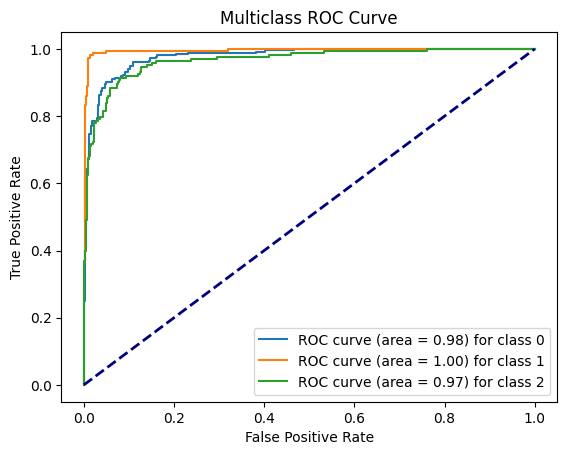

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_multiclass_roc(model, val_ds, num_classes):
    y_true = []
    y_scores = []

    for images, labels in val_ds:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_scores.extend(predictions)

    # Convert to numpy arrays
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    y_scores = np.array(y_scores)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Example usage
num_classes = len(class_names)  # Assuming class_names is defined
plot_multiclass_roc(model, val_ds, num_classes)


In [42]:
pip install scikit-image


Note: you may need to restart the kernel to use updated packages.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

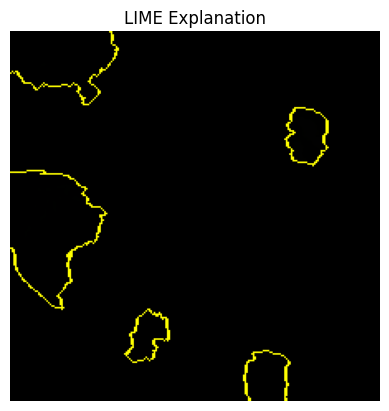

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Define the LIME explanation function
def lime_explanation(model, val_ds):
    # Get an image from the validation dataset
    for images, labels in val_ds.take(1):  # Take one batch
        img_array = images[0].numpy()  # Get the first image
        break

    # Create LIME explainer
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img_array, 
        model.predict, 
        top_labels=1, 
        hide_color=0, 
        num_samples=1000
    )

    # Get the explanation for the top label
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], 
        positive_only=True, 
        num_features=5, 
        hide_rest=True
    )
    
    # Mark the boundaries on the image
    img_boundry = mark_boundaries(temp / 255.0, mask)
    
    # Display the image with LIME boundaries
    plt.imshow(img_boundry)
    plt.title('LIME Explanation')
    plt.axis('off')
    plt.show()

# Example usage
lime_explanation(model, val_ds)


In [65]:
import tensorflow as tf
import os
from tensorflow.keras import layers
import numpy as np
from PIL import Image

# Define the dataset path and output path for preprocessed images
dataset_path = r"C:\Users\sakib\Downloads\Tomato\Dataset"
preprocessed_output_path = r"C:\Users\sakib\Downloads\Tomato\Preprocessed_Dataset"

# Create output directory if it doesn't exist
if not os.path.exists(preprocessed_output_path):
    os.makedirs(preprocessed_output_path)

# Define image preprocessing function
def preprocess_and_save_image(image_path, output_path, image_size=(224, 224)):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = img / 255.0  # Rescale to [0, 1]
    img = tf.image.convert_image_dtype(img, dtype=tf.uint8)  # Convert back to uint8 format

    # Convert image tensor to numpy array and save
    img_array = img.numpy()
    pil_img = Image.fromarray(img_array)
    pil_img.save(output_path)

# Function to process the full dataset
def preprocess_full_dataset(dataset_path, output_path):
    class_names = sorted(os.listdir(dataset_path))
    for class_name in class_names:
        class_folder = os.path.join(dataset_path, class_name)
        output_class_folder = os.path.join(output_path, class_name)
        
        # Create subfolder in the output directory
        if not os.path.exists(output_class_folder):
            os.makedirs(output_class_folder)

        # Process each image in the class folder
        for image_name in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_name)
            output_image_path = os.path.join(output_class_folder, image_name)

            # Preprocess and save image
            preprocess_and_save_image(image_path, output_image_path)
            print(f"Preprocessed and saved {image_name} to {output_image_path}")

# Preprocess the full dataset
preprocess_full_dataset(dataset_path, preprocessed_output_path)
print("All images have been preprocessed and saved.")


Preprocessed and saved 20231212_124843.jpg to C:\Users\sakib\Downloads\Tomato\Preprocessed_Dataset\Healthly\20231212_124843.jpg
Preprocessed and saved 20231212_124856.jpg to C:\Users\sakib\Downloads\Tomato\Preprocessed_Dataset\Healthly\20231212_124856.jpg
Preprocessed and saved 20231212_124913.jpg to C:\Users\sakib\Downloads\Tomato\Preprocessed_Dataset\Healthly\20231212_124913.jpg
Preprocessed and saved 20231212_124914.jpg to C:\Users\sakib\Downloads\Tomato\Preprocessed_Dataset\Healthly\20231212_124914.jpg
Preprocessed and saved 20231212_124920.jpg to C:\Users\sakib\Downloads\Tomato\Preprocessed_Dataset\Healthly\20231212_124920.jpg
Preprocessed and saved 20231212_124931.jpg to C:\Users\sakib\Downloads\Tomato\Preprocessed_Dataset\Healthly\20231212_124931.jpg
Preprocessed and saved 20231212_124933.jpg to C:\Users\sakib\Downloads\Tomato\Preprocessed_Dataset\Healthly\20231212_124933.jpg
Preprocessed and saved 20231212_124943.jpg to C:\Users\sakib\Downloads\Tomato\Preprocessed_Dataset\Healt

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


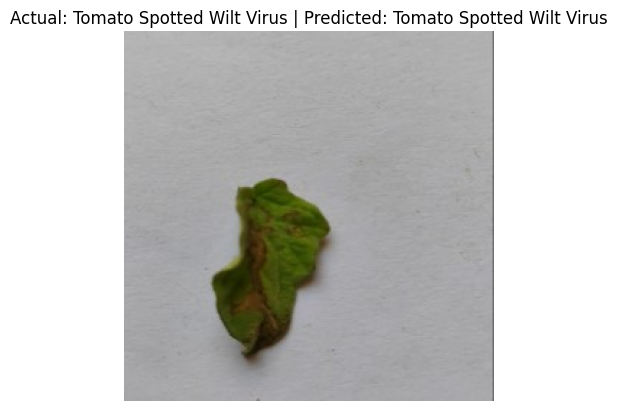

Actual class: Tomato Spotted Wilt Virus, Predicted class: Tomato Spotted Wilt Virus


In [64]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

# Path to the dataset folder
dataset_path = r"C:\Users\sakib\Downloads\Tomato\Dataset"

# Get class names from the dataset
def get_class_names(dataset_path):
    return sorted(os.listdir(dataset_path))

class_names = get_class_names(dataset_path)

# Function to get a random image path and its actual class from the dataset
def get_random_image_path_and_class(dataset_path):
    class_folders = [os.path.join(dataset_path, class_folder) for class_folder in os.listdir(dataset_path)]
    random_class_folder = random.choice(class_folders)
    random_image = random.choice(os.listdir(random_class_folder))
    actual_class = os.path.basename(random_class_folder)
    return os.path.join(random_class_folder, random_image), actual_class

# Function to preprocess a single image for prediction
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0
    return img

# Function to predict the class of a random image and display results
def predict_and_display_random_image(model):
    image_path, actual_class = get_random_image_path_and_class(dataset_path)  # Get a random image and its actual class
    processed_image = preprocess_image(image_path)
    processed_image = tf.expand_dims(processed_image, axis=0)  # Add batch dimension
    predictions = model.predict(processed_image)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]

    # Display the image with actual and predicted class labels
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Actual: {actual_class} | Predicted: {predicted_class}")
    plt.show()

    return actual_class, predicted_class

# Example usage: predict and display a random image
actual_class, predicted_class = predict_and_display_random_image(model)
print(f"Actual class: {actual_class}, Predicted class: {predicted_class}")


In [98]:
# Save the model
model.save('best_model_saved.keras')  # Save your model

print(f'Model saved as best_model_saved.keras')

Model saved as best_model_saved.keras


In [105]:
import numpy as np
import os
import random
import cv2
from keras.models import load_model
from lime import lime_image
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# Load your trained model
model = load_model('best_model_saved.keras')  # Ensure the model is correctly loaded

# Function to load a random image from the dataset
def load_random_image(dataset_path):
    class_names = os.listdir(dataset_path)
    random_class = random.choice(class_names)
    random_image_path = os.path.join(dataset_path, random_class, random.choice(os.listdir(os.path.join(dataset_path, random_class))))
    
    img_array = cv2.imread(random_image_path)
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img_array = cv2.resize(img_array, (224, 224))  # Resize to model input size (224x224)
    img_array = img_to_array(img_array) / 255.0  # Normalize the image
    return random_image_path, img_array

# Load a random image
dataset_path = r"C:\Users\sakib\Downloads\Tomato\Dataset"  # Adjust path as needed
random_image_path, img_array = load_random_image(dataset_path)

# Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Function to predict the model
def model_predict(images):
    images = np.array(images)  # Ensure input is a numpy array
    return model.predict(images)  # Call the model's predict method

# Explain the image prediction
explanation = explainer.explain_instance(
    img_array,
    model_predict,  # Use the reshaped input for model prediction
    top_labels=1,  # Change to 1 to get the top label
    hide_color=0,
    num_samples=1000
)

# Get the top label (most probable prediction)
top_label = explanation.top_labels[0]

# Get the image and mask
temp, mask = explainer.get_image_and_mask(
    top_label,
    positive_only=True,
    hide_rest=False,
    min_weight=0.05
)

# Display the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_array)
plt.title("Original Image")
plt.axis('off')

# Display the LIME explanation
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.axis('off')

plt.show()

# Save the model as best_model_saved.keras
model.save('best_model_saved.keras')  # Save your model

print(f'Model saved as best_model_saved.keras')


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/

AttributeError: 'LimeImageExplainer' object has no attribute 'get_image_and_mask'